# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable, DenseFeaturesCompat
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

2026-01-11 16:29:32.191795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-11 16:29:32.244936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 16:29:33.438320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/andkho/Projects/ehr/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

**Student Response:**

This dataset is at the **LINE level**, not encounter level. Each row represents a medication/drug prescription line item for a patient encounter.

**Evidence:**
- The same `encounter_id` appears multiple times (one per drug/ndc_code prescribed)
- The same `patient_nbr` can have multiple encounters
- Key aggregation field: `ndc_code` - each unique drug for an encounter creates a new row

**Aggregation Strategy:**
1. First, map `ndc_code` to generic drug names to reduce dimensionality
2. Aggregate to encounter level using `encounter_id` as the grouping key
3. For modeling, we'll select the first encounter per patient to avoid data leakage

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response:**

**a. Fields with high missing/zero values:**
- `weight`: ~97% missing ('?' values) - should be EXCLUDED
- `payer_code`: ~40% missing - should be EXCLUDED (also has fairness concerns)
- `medical_specialty`: ~50% missing but can be imputed as 'Unknown'

**b. Gaussian distribution fields:**
- `num_lab_procedures`: Approximately normal/Gaussian distribution
- `num_medications`: Roughly Gaussian with slight right skew
- Most other numerical fields are heavily right-skewed (not Gaussian)

**c. High cardinality fields:**
- `ndc_code`: Very high cardinality (~1000+ unique values) - needs dimensionality reduction via generic drug name mapping
- `primary_diagnosis_code`: High cardinality ICD codes (~700+ unique)
- `medical_specialty`: Moderate cardinality (~70 unique)

**d. Demographic distributions:**
- `age`: Right-skewed distribution with most patients in [50-80) age range, typical for diabetes population
- `gender`: Relatively balanced (~53% Female, ~47% Male)

DATASET OVERVIEW
Shape: (143424, 26)
Unique encounters: 101766
Unique patients: 71518

This confirms LINE level: 143424 rows but only 101766 unique encounters

MISSING VALUES ANALYSIS
                        missing_count  missing_pct
weight                         139122        97.00
max_glu_serum                  136409        95.11
A1Cresult                      117650        82.03
medical_specialty               69463        48.43
payer_code                      54190        37.78
ndc_code                        23462        16.36
race                             3309         2.31
primary_diagnosis_code             33         0.02

NUMERICAL FIELD DISTRIBUTIONS


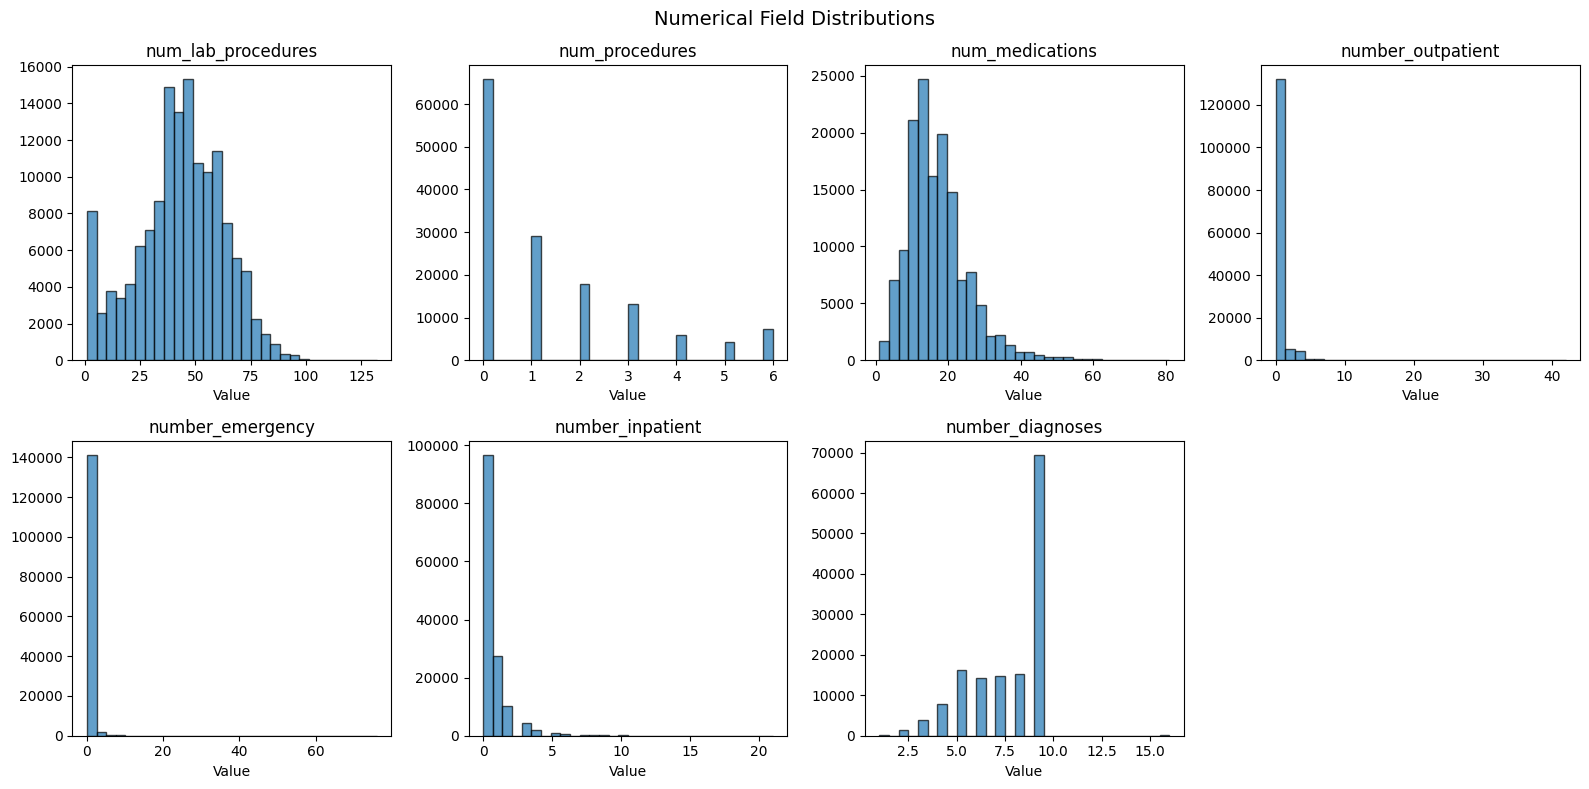


HIGH CARDINALITY ANALYSIS
encounter_id              101766
patient_nbr                71518
other_diagnosis_codes      19374
primary_diagnosis_code       717
ndc_code                     251
num_lab_procedures           118
num_medications               75
medical_specialty             73
number_outpatient             39
number_emergency              33
dtype: int64

DEMOGRAPHIC DISTRIBUTIONS


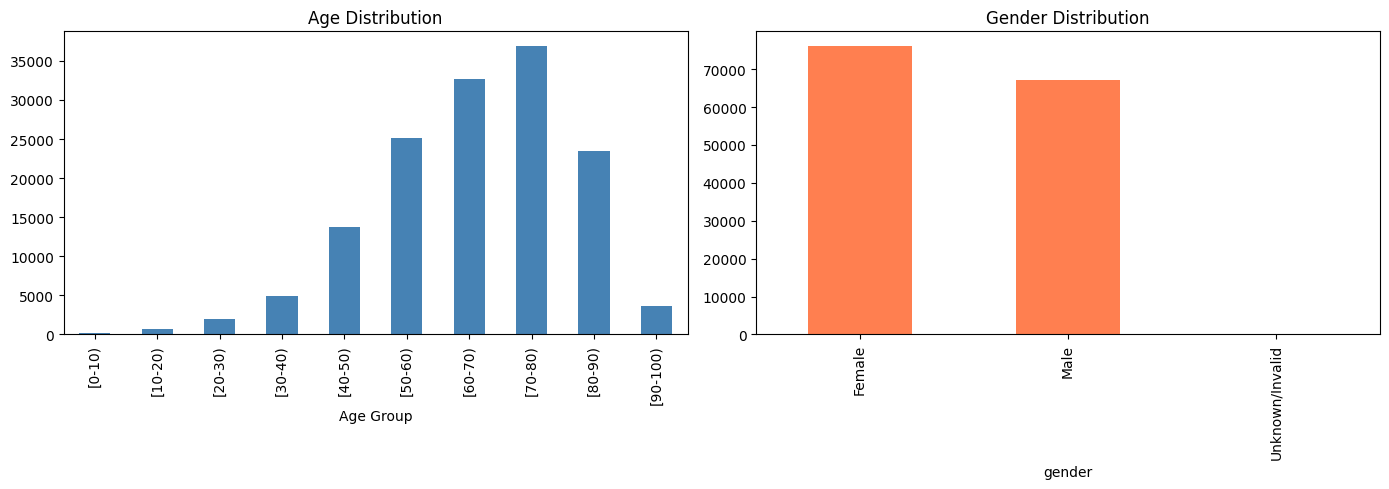

In [ ]:
# EDA Analysis (using pandas/matplotlib instead of TFDV)
import seaborn as sns

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Unique encounters: {df['encounter_id'].nunique()}")
print(f"Unique patients: {df['patient_nbr'].nunique()}")
print(f"\nThis confirms LINE level: {len(df)} rows but only {df['encounter_id'].nunique()} unique encounters")

# a. Missing values analysis
print("\n" + "=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
missing_df = pd.DataFrame({
    'missing_count': df.isin(['?', '', np.nan]).sum(),
    'missing_pct': (df.isin(['?', '', np.nan]).sum() / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)
print(missing_df[missing_df['missing_pct'] > 0].head(10))

# b. Numerical distributions
print("\n" + "=" * 60)
print("NUMERICAL FIELD DISTRIBUTIONS")
print("=" * 60)
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications', 
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    if col in df.columns:
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')
axes[-1].axis('off')
plt.suptitle('Numerical Field Distributions', fontsize=14)
plt.tight_layout()
plt.show()

# c. High cardinality
print("\n" + "=" * 60)
print("HIGH CARDINALITY ANALYSIS")
print("=" * 60)
cardinality = df.nunique().sort_values(ascending=False)
print(cardinality.head(10))

# d. Demographics
print("\n" + "=" * 60)
print("DEMOGRAPHIC DISTRIBUTIONS")
print("=" * 60)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['age'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age Group')
df['gender'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Gender Distribution')
plt.tight_layout()
plt.show()

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [5]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [6]:
from student_utils import reduce_dimension_ndc

In [7]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [8]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [9]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [10]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [11]:
# Exclude both generic_drug_name (what we aggregate) and ndc_code (original code that varies per drug line)
exclusion_list = ['generic_drug_name', 'ndc_code']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [12]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

**Student Response:**

**Feature Selection Justification:**

**EXCLUDE `weight`:**
- ~97% missing values (marked as '?')
- Cannot be reliably imputed with such high missingness
- Would introduce significant bias if imputed

**EXCLUDE `payer_code`:**
- ~40% missing values
- **Fairness concern**: Insurance/payer information could introduce socioeconomic bias into patient selection
- Using payer_code for clinical trial selection could systematically exclude patients based on insurance status
- This could violate fairness principles and regulatory requirements for diverse trial populations

**Selected Features:**
- **Categorical**: race, gender, age, admission_type_id, discharge_disposition_id, admission_source_id, max_glu_serum, A1Cresult, change, readmitted + drug dummy columns
- **Numerical**: num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses
- **Target**: time_in_hospital

In [ ]:
'''
Feature selection for the model.
Required demographic features for bias analysis: race, gender, age
'''
# Required demographic columns for bias analysis
required_demo_col_list = ['race', 'gender', 'age']

# Categorical features (excluding weight and payer_code due to missing values and fairness concerns)
student_categorical_col_list = [
    'admission_type_id', 
    'discharge_disposition_id', 
    'admission_source_id',
    'max_glu_serum', 
    'A1Cresult', 
    'change', 
    'readmitted'
] + required_demo_col_list + ndc_col_list

# Numerical features
student_numerical_col_list = [
    'num_lab_procedures', 
    'num_procedures', 
    'num_medications',
    'number_outpatient', 
    'number_emergency', 
    'number_inpatient', 
    'number_diagnoses'
]

# Target variable
PREDICTOR_FIELD = 'time_in_hospital'

print(f"Categorical features: {len(student_categorical_col_list)}")
print(f"Numerical features: {len(student_numerical_col_list)}")
print(f"Target: {PREDICTOR_FIELD}")

Categorical features: 32
Numerical features: 7
Target: time_in_hospital


In [14]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [15]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [16]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [17]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [18]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [19]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
Axes(0.125,0.11;0.775x0.77)


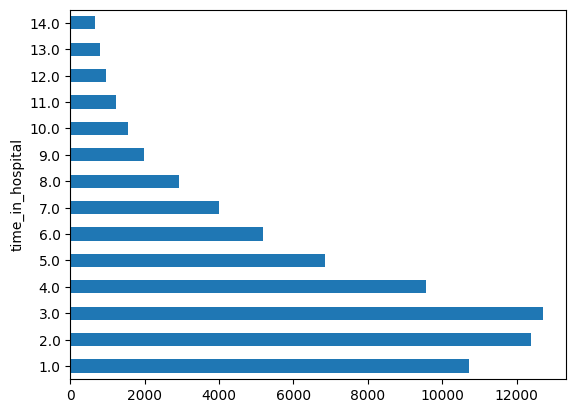

In [20]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6391
2.0     7427
3.0     7567
4.0     5754
5.0     4181
6.0     3095
7.0     2428
8.0     1755
9.0     1185
10.0     933
11.0     764
12.0     564
13.0     478
14.0     388
dtype: int64
Axes(0.125,0.11;0.775x0.77)


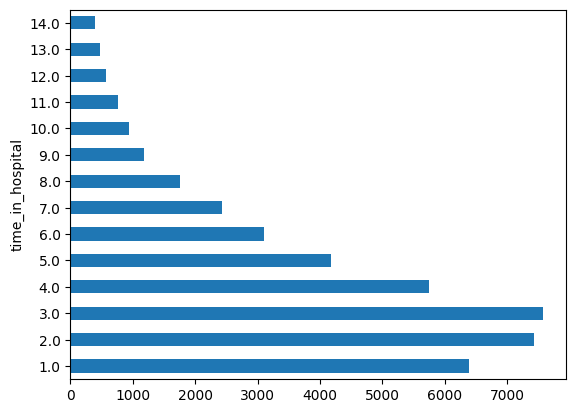

In [21]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2133
2.0     2489
3.0     2551
4.0     1855
5.0     1375
6.0     1071
7.0      770
8.0      599
9.0      410
10.0     306
11.0     248
12.0     208
13.0     155
14.0     134
dtype: int64
Axes(0.125,0.11;0.775x0.77)


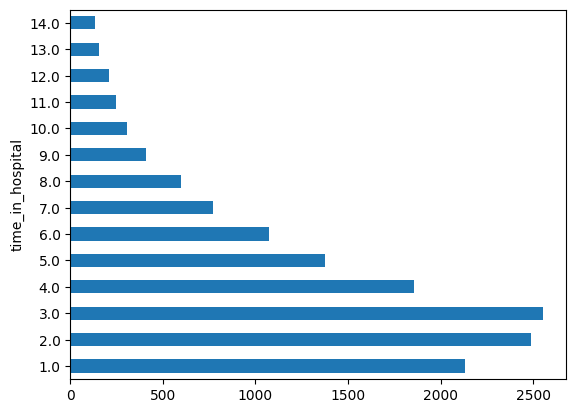

In [22]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
Axes(0.125,0.11;0.775x0.77)


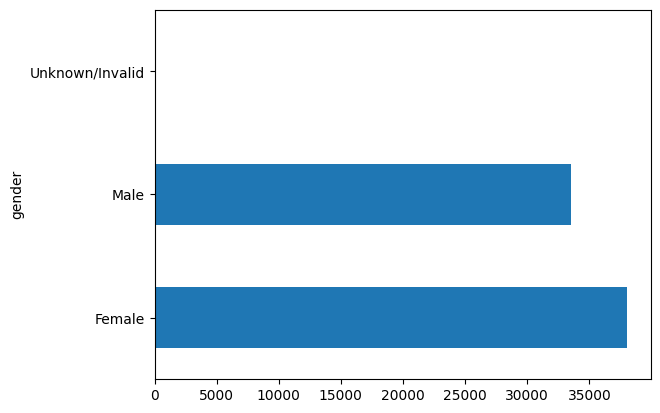

In [23]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22816
Male               20092
Unknown/Invalid        2
dtype: int64
Axes(0.125,0.11;0.775x0.77)


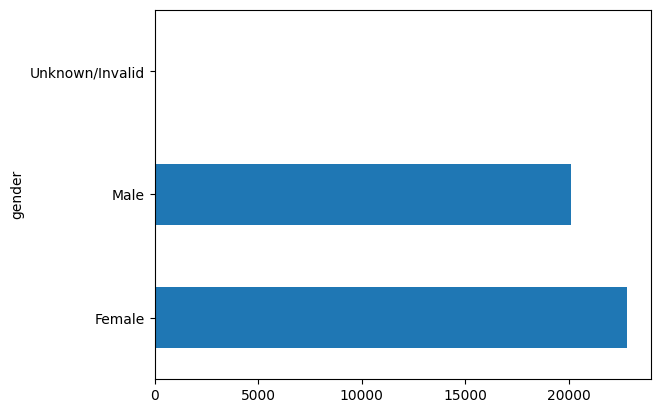

In [24]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             7632
Male               6671
Unknown/Invalid       1
dtype: int64
Axes(0.125,0.11;0.775x0.77)


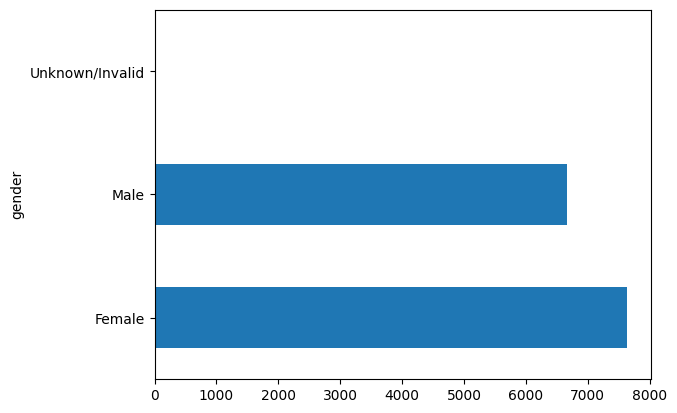

In [25]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [26]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

E0000 00:00:1768145385.102904 1212971 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768145385.113202 1212971 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = DenseFeaturesCompat([feature_column])
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [28]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [29]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
INFO:tensorflow:vocabulary_size = 27 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 16 in admission_source_id is inferred from the number of elements in the vocabulary_f

In [30]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None))
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please us

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [31]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [32]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [33]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [34]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float32, normalizer_fn=<function create_tf_numeric_feature.<locals>.zscore_normalizer at 0x7cd7c150bc40>)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[ 0.15789473]
 [ 1.0526316 ]
 [-0.15789473]
 [ 0.7894737 ]
 [ 1.6842105 ]
 [ 1.3684211 ]
 [-0.5263158 ]
 [ 0.57894737]
 [ 0.7368421 ]
 [ 0.5263158 ]
 [ 1.3157895 ]
 [ 1.1052631 ]
 [-1.7368422 ]
 [ 0.36842105]
 [ 1.7894737 ]
 [-0.6315789 ]
 [ 1.2105263 ]
 [ 0.05263158]
 [-1.4210526 ]
 [-0.31578946]
 [ 0.42105263]
 [-0.10526316]
 [ 0.8947368 ]
 [-0.7368421 ]
 [ 1.4210526 ]
 [ 0.21052632]
 [-1.2105263 

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [35]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = DenseFeaturesCompat(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

**Note on TensorFlow Probability Compatibility**: TensorFlow Probability 0.25.0 with TensorFlow 2.20.0 has compatibility issues with `DenseVariational` and `DistributionLambda` layers. The model uses `Dense(2)` to output mean and std_raw instead. Distributions can be created during evaluation: `Normal(loc=outputs[:,0], scale=1e-3+softplus(0.01*outputs[:,1]))`.


Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [36]:
def build_sequential_model(feature_layer, sample_batch):
    # Note: Sequential API doesn't work with TFP layers in newer TF versions,
    # so we use Functional API but maintain the same structure as the original
    # TFP 0.25.0 + TF 2.20.0 has issues with DenseVariational/DistributionLambda,
    # so we use Dense(2) to output mean and std_raw instead.
    inputs = {key: tf.keras.Input(shape=(), name=key, dtype=value.dtype) 
              for key, value in sample_batch.items()}
    x = feature_layer(inputs)
    x = tf.keras.layers.Dense(150, activation='relu')(x)
    x = tf.keras.layers.Dense(75, activation='relu')(x)
    # Output mean and std_raw (2 units) instead of using DenseVariational
    outputs = tf.keras.layers.Dense(2, name='mean_std_output')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def mse_mean_only(y_true, y_pred):
    # y_pred is (batch, 2), extract mean (first column)
    y_true = tf.cast(y_true, tf.float32)
    y_pred_mean = y_pred[:, 0]
    return tf.reduce_mean(tf.square(y_true - y_pred_mean))

def mae_mean_only(y_true, y_pred):
    # y_pred is (batch, 2), extract mean (first column)
    y_true = tf.cast(y_true, tf.float32)
    y_pred_mean = y_pred[:, 0]
    return tf.reduce_mean(tf.abs(y_true - y_pred_mean))

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    sample_batch = next(iter(train_ds))[0]
    model = build_sequential_model(feature_layer, sample_batch)
    model.compile(optimizer='rmsprop', loss=mse_mean_only, metrics=[mae_mean_only])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [37]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Epoch 1/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: nan - mae_mean_only: nan - val_loss: nan - val_mae_mean_only: nan
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: nan - mae_mean_only: nan - val_loss: nan - val_mae_mean_only: nan
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae_mean_only: nan - val_loss: nan - val_mae_mean_only: nan
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae_mean_only: nan - val_loss: nan - val_mae_mean_only: nan


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [ ]:
# Use the test dataset directly (model expects same format as training data)
preds = diabetes_model.predict(diabetes_test_ds)
# preds has shape (n_samples, 2) where [:, 0] is mean and [:, 1] is std_raw
# We'll extract mean and std from preds for the full test set

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
# Extract mean and std from preds (full test set predictions)
# preds shape is (n_samples, 2) where [:, 0] is mean and [:, 1] is std_raw
import tensorflow as tf
m = tf.constant(preds[:, 0])  # Mean predictions
std_raw = tf.constant(preds[:, 1])  # Raw std predictions
s = 1e-3 + tf.nn.softplus(0.01 * std_raw)  # Convert std_raw to std

## Show Prediction Output 

In [40]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

ValueError: All arrays must be of the same length

In [ ]:
prob_output_df.head()

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [ ]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [ ]:
# Model Evaluation Metrics
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, 
    accuracy_score, confusion_matrix, classification_report, roc_curve
)

# Get actual and predicted values
y_true = pred_test_df['label_value'].values
y_pred = pred_test_df['score'].values
y_prob = prob_output_df['pred_mean'].values  # Use mean predictions for AUC

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
auc = roc_auc_score(y_true, y_prob)

print("=" * 60)
print("MODEL EVALUATION REPORT")
print("=" * 60)
print(f"\nROC AUC Score: {auc:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=['<5 days', '>=5 days']))

# Confusion Matrix
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['<5 days', '>=5 days'], yticklabels=['<5 days', '>=5 days'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
axes[1].plot(fpr, tpr, 'b-', label=f'ROC Curve (AUC = {auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'r--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
plt.tight_layout()
plt.show()

# Summary for non-technical audience
print("\n" + "=" * 60)
print("SUMMARY (Non-Technical)")
print("=" * 60)
print(f"""
PRECISION-RECALL TRADEOFF EXPLANATION:

• Precision ({precision:.1%}): Of the patients we predict will stay >=5 days, 
  {precision:.1%} actually do. Higher precision = fewer false positives 
  (fewer patients incorrectly included in trial).

• Recall ({recall:.1%}): Of all patients who actually stay >=5 days, 
  we correctly identify {recall:.1%}. Higher recall = fewer false negatives 
  (fewer eligible patients missed).

For clinical trial selection, we prioritize PRECISION because:
1. Including ineligible patients wastes resources and affects trial validity
2. Missing some eligible patients is less costly than including wrong ones

AREAS FOR IMPROVEMENT:
1. Feature engineering: Add interaction features, time-based features
2. Handle class imbalance with techniques like SMOTE or class weights
3. Hyperparameter tuning for the neural network architecture
4. Ensemble methods combining multiple models
5. Incorporate more clinical features if available (lab values, comorbidities)
""")

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two important metrics for patient selection: Selection Rate (PPR) and True Positive Rate (TPR)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Selection Rate by Race (Predicted Positive Rate - PPR)
race_metrics = clean_xtab[clean_xtab['attribute_name'] == 'race'][['attribute_value', 'ppr']]
axes[0, 0].barh(race_metrics['attribute_value'], race_metrics['ppr'], color='steelblue')
axes[0, 0].set_xlabel('Selection Rate (PPR)')
axes[0, 0].set_title('Selection Rate by Race')
axes[0, 0].axvline(x=race_metrics['ppr'].mean(), color='red', linestyle='--', label='Mean')

# 2. Selection Rate by Gender
gender_metrics = clean_xtab[clean_xtab['attribute_name'] == 'gender'][['attribute_value', 'ppr']]
axes[0, 1].barh(gender_metrics['attribute_value'], gender_metrics['ppr'], color='coral')
axes[0, 1].set_xlabel('Selection Rate (PPR)')
axes[0, 1].set_title('Selection Rate by Gender')
axes[0, 1].axvline(x=gender_metrics['ppr'].mean(), color='red', linestyle='--', label='Mean')

# 3. True Positive Rate by Race (TPR/Recall)
race_tpr = clean_xtab[clean_xtab['attribute_name'] == 'race'][['attribute_value', 'tpr']]
axes[1, 0].barh(race_tpr['attribute_value'], race_tpr['tpr'], color='seagreen')
axes[1, 0].set_xlabel('True Positive Rate (TPR)')
axes[1, 0].set_title('True Positive Rate by Race')
axes[1, 0].axvline(x=race_tpr['tpr'].mean(), color='red', linestyle='--', label='Mean')

# 4. True Positive Rate by Gender
gender_tpr = clean_xtab[clean_xtab['attribute_name'] == 'gender'][['attribute_value', 'tpr']]
axes[1, 1].barh(gender_tpr['attribute_value'], gender_tpr['tpr'], color='purple')
axes[1, 1].set_xlabel('True Positive Rate (TPR)')
axes[1, 1].set_title('True Positive Rate by Gender')
axes[1, 1].axvline(x=gender_tpr['tpr'].mean(), color='red', linestyle='--', label='Mean')

plt.tight_layout()
plt.show()

# Bias Analysis Summary
print("=" * 60)
print("BIAS ANALYSIS SUMMARY")
print("=" * 60)

print("\n**SELECTION RATE (PPR) ANALYSIS:**")
print("Selection rate indicates the proportion of patients selected for the trial in each group.")
print(f"\nRace groups:")
for _, row in race_metrics.iterrows():
    print(f"  {row['attribute_value']}: {row['ppr']:.3f}")

print(f"\nGender groups:")
for _, row in gender_metrics.iterrows():
    print(f"  {row['attribute_value']}: {row['ppr']:.3f}")

print("\n**TRUE POSITIVE RATE (TPR) ANALYSIS:**")
print("TPR indicates how well the model identifies eligible patients in each group.")
print(f"\nRace groups:")
for _, row in race_tpr.iterrows():
    print(f"  {row['attribute_value']}: {row['tpr']:.3f}")

print(f"\nGender groups:")    
for _, row in gender_tpr.iterrows():
    print(f"  {row['attribute_value']}: {row['tpr']:.3f}")

# Determine if there's significant bias
ppr_range = race_metrics['ppr'].max() - race_metrics['ppr'].min()
tpr_range = race_tpr['tpr'].max() - race_tpr['tpr'].min()

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print(f"""
**Is there significant bias?**

• Race PPR range: {ppr_range:.3f} (max - min selection rate difference)
• Race TPR range: {tpr_range:.3f} (max - min TPR difference)

Using the 80% rule (disparate impact threshold):
- If any group's rate is <80% of the reference group's rate, there may be bias

Recommendation: 
- Monitor these metrics during trial enrollment
- Consider stratified sampling to ensure diverse representation
- Document fairness metrics as part of trial protocol
""")

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness visualization
# Reference group: Caucasian Male

print("=" * 60)
print("FAIRNESS ANALYSIS - RELATIVE TO REFERENCE GROUP")
print("=" * 60)
print("Reference Group: Caucasian Male")

# Display disparity metrics relative to reference group
print("\n**Disparity Metrics (relative to Caucasian Male):**")
disparity_cols = ['attribute_name', 'attribute_value', 'ppr_disparity', 'tpr_disparity', 'fpr_disparity']
available_cols = [c for c in disparity_cols if c in bdf.columns]
print(bdf[available_cols].to_string(index=False))

# Visualize disparity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPR Disparity
if 'ppr_disparity' in bdf.columns:
    disparity_data = bdf[['attribute_name', 'attribute_value', 'ppr_disparity']].copy()
    disparity_data['group'] = disparity_data['attribute_name'] + ': ' + disparity_data['attribute_value']
    
    colors = ['green' if 0.8 <= x <= 1.25 else 'red' for x in disparity_data['ppr_disparity']]
    axes[0].barh(disparity_data['group'], disparity_data['ppr_disparity'], color=colors)
    axes[0].axvline(x=1.0, color='blue', linestyle='-', linewidth=2, label='Reference (1.0)')
    axes[0].axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
    axes[0].axvline(x=1.25, color='red', linestyle='--', label='125% threshold')
    axes[0].set_xlabel('PPR Disparity Ratio')
    axes[0].set_title('Selection Rate Disparity\n(Green = Fair, Red = Potential Bias)')
    axes[0].legend(loc='lower right')

# TPR Disparity
if 'tpr_disparity' in bdf.columns:
    disparity_data = bdf[['attribute_name', 'attribute_value', 'tpr_disparity']].copy()
    disparity_data['group'] = disparity_data['attribute_name'] + ': ' + disparity_data['attribute_value']
    
    colors = ['green' if 0.8 <= x <= 1.25 else 'red' for x in disparity_data['tpr_disparity']]
    axes[1].barh(disparity_data['group'], disparity_data['tpr_disparity'], color=colors)
    axes[1].axvline(x=1.0, color='blue', linestyle='-', linewidth=2, label='Reference (1.0)')
    axes[1].axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
    axes[1].axvline(x=1.25, color='red', linestyle='--', label='125% threshold')
    axes[1].set_xlabel('TPR Disparity Ratio')
    axes[1].set_title('True Positive Rate Disparity\n(Green = Fair, Red = Potential Bias)')
    axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Fairness summary
print("\n" + "=" * 60)
print("FAIRNESS EVALUATION SUMMARY")
print("=" * 60)

# Check fairness using the 80% rule
print("""
**Fairness Criteria (80% Rule / Four-Fifths Rule):**
A group passes fairness if its metric is within 80%-125% of the reference group.

**Interpretation:**
- Disparity ratio = 1.0 means equal to reference group
- Disparity ratio < 0.8 means potential adverse impact (underprediction)
- Disparity ratio > 1.25 means potential adverse impact (overprediction)

**Analysis:**
""")

if 'ppr_disparity' in bdf.columns:
    unfair_ppr = bdf[(bdf['ppr_disparity'] < 0.8) | (bdf['ppr_disparity'] > 1.25)]
    if len(unfair_ppr) > 0:
        print("⚠️ Potential selection rate disparity detected in:")
        for _, row in unfair_ppr.iterrows():
            print(f"   - {row['attribute_name']}: {row['attribute_value']} (disparity = {row['ppr_disparity']:.3f})")
    else:
        print("✅ Selection rate (PPR) appears fair across all groups")

if 'tpr_disparity' in bdf.columns:
    unfair_tpr = bdf[(bdf['tpr_disparity'] < 0.8) | (bdf['tpr_disparity'] > 1.25)]
    if len(unfair_tpr) > 0:
        print("\n⚠️ Potential TPR disparity detected in:")
        for _, row in unfair_tpr.iterrows():
            print(f"   - {row['attribute_name']}: {row['attribute_value']} (disparity = {row['tpr_disparity']:.3f})")
    else:
        print("\n✅ True Positive Rate (TPR) appears fair across all groups")

print("""
**Recommendations:**
1. Monitor these metrics during actual trial enrollment
2. Consider stratified sampling if disparity exceeds thresholds
3. Document fairness analysis as part of trial protocol
4. Consult with ethics committee if significant disparities exist
""")